# 설명
많은 사회적 프로그램들은 적절한 사람들에게 충분한 도움을 주는 것을 확실히 하는데 어려움을 겪고 있다. 프로그램이 인구의 가장 가난한 부분에 초점을 맞출 때 특히 까다롭다. 세계에서 가장 가난한 사람들은 전형적으로 그들이 자격이 있다는 것을 증명하기 위해 필요한 수입과 비용 기록을 제공할 수 없다. 코스타리카를 넘어, 많은 나라들이 사회적 요구를 부정확하게 평가하는 것과 같은 문제에 직면해 있다.

PMT(proxy means Test)라 불리는 인기 알고리즘은 가족의 관찰 가능한 가정 속성인 벽면이나 천장의 소재와 함께 소득 적격성을 검증하거나, 이를 분류하고, 필요 수준을 예측하는 데 사용된다. 이것은 개선이지만 그 지역의 인구가 증가하고 빈곤이 감소함에 따라 정확도는 여전히 문제가 되고 있다.

이 경쟁에서는, 가계 빈곤 예측의 정확성 향상을 목표로, 유사한 속성과 데이터셋을 공유한다. 이 커널에서 나는 탐사, 피처 엔지니어링, 그리고 베이스라인 모델을 수행했다.

# 1. Dataset Preparation 
해당 커널에서는 데이터 시각화 시 plotly의 메소드를 이용할 것이다.

In [ ]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.plotly as py
from plotly import tools
from datetime import date
import pandas as pd
import numpy as np 
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import random 
import warnings
import operator
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

print ("Train Dataset: Rows, Columns: ", train.shape)
print ("Test Dataset: Rows, Columns: ", test.shape)

In [ ]:
print ("Glimpse of Train Dataset: ")
train.head()

In [ ]:
print ("Summary of Train Dataset: ")
train.describe()

각 컬럼에 대한 설명은 https://www.kaggle.com/youhanlee/3250feats-532-feats-using-shap-lb-0-436 을 참고할 것

In [ ]:
print ("Top Columns having missing values")
missmap = train.isnull().sum().to_frame() # 널 값의 갯수를 데이터프림화 한다.
missmap = missmap.sort_values(0, ascending = False) # ascending : 오름차순?
missmap.head() # 전체를 뽑아 보니 널값이 없는것도 많음

# 2. Different Levels of Poverty Household Groups

In [ ]:
target = train['Target'].value_counts().to_frame()
levels = ["NonVulnerable", "Moderate Poverty", "Vulnerable", "Extereme Poverty"]
trace = go.Bar(y=target.Target, x=levels, marker=dict(color='orange', opacity=0.6)) # dict : 키와 값을 한 쌍으로 가지는 자료형
layout = dict(title="Household Poverty Levels", margin=dict(l=200), width=800, height=400)
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig)

# 3. What do households own ?

In [ ]:
def compare_plot(col, title): # compare_plot 함수 정의
    tr1 = train[train['Target'] == 1][col].value_counts().to_dict()
    tr2 = train[train['Target'] == 2][col].value_counts().to_dict()
    tr3 = train[train['Target'] == 3][col].value_counts().to_dict()
    tr4 = train[train['Target'] == 4][col].value_counts().to_dict()
    # target의 값에 따라 데이터를 분리하고, 해당 데이터들을 사전 자료형으로 변경함
    
    xx = ['Extereme', 'Moderate', 'Vulnerable', 'NonVulnerable']
    trace1 = go.Bar(y=[tr1[0], tr2[0], tr3[0], tr4[0]], name="Not Present", x=xx, marker=dict(color="orange", opacity=0.6))
    trace2 = go.Bar(y=[tr1[1], tr2[1], tr3[1], tr4[1]], name="Present", x=xx, marker=dict(color="purple", opacity=0.6))
    
    return trace1, trace2 
    
tr1, tr2 = compare_plot("v18q", "Tablet")
tr3, tr4 = compare_plot("refrig", "Refrigirator")
tr5, tr6 = compare_plot("computer", "Computer")
tr7, tr8 = compare_plot("television", "Television")
tr9, tr10 = compare_plot("mobilephone", "MobilePhone")
titles = ["Tablet", "Refrigirator", "Computer", "Television", "MobilePhone"]
# col 에 해당되는 것들의 의미가 title

fig = tools.make_subplots(rows=3, cols=2, print_grid=False, subplot_titles=titles)
fig.append_trace(tr1, 1, 1)
fig.append_trace(tr2, 1, 1)
fig.append_trace(tr3, 1, 2)
fig.append_trace(tr4, 1, 2)
fig.append_trace(tr5, 2, 1)
fig.append_trace(tr6, 2, 1)
fig.append_trace(tr7, 2, 2)
fig.append_trace(tr8, 2, 2)
fig.append_trace(tr9, 3, 1)
fig.append_trace(tr10, 3, 1)
# 그래프들의 위치 지정

fig['layout'].update(height=1000, title="What do Households Own", barmode="stack", showlegend=False)
iplot(fig)

# 4. Key Characteristics of the Households

4.1 Household Materials and Methods

In [ ]:
def find_prominent(row, mats): 
    for c in mats:
        if row[c] == 1: 
            return c
    return 
# row[c]가 1인 거 반환

def combine(starter, colname, title, replacemap): # combine 함수 정의 
    mats = [c for c in train.columns if c.startswith(starter)] # startswith : 해당 문자열로 시작할 경우 ture 반환
    train[colname] = train.apply(lambda row : find_prominent(row, mats), axis=1)
    # apply : train에 모든 컬럼에 대해 해당 함수를 적용시킨다
    # lamda : 간단한 함수 형식
    train[colname] = train[colname].apply(lambda x : replacemap[x] if x != None else x )
    
    om1 = train[train['Target'] == 1][colname].value_counts().to_frame()
    om2 = train[train['Target'] == 2][colname].value_counts().to_frame()
    om3 = train[train['Target'] == 3][colname].value_counts().to_frame()
    om4 = train[train['Target'] == 4][colname].value_counts().to_frame()

    trace1 = go.Bar(y=om1[colname], x=om1.index, name="Extereme", marker=dict(color='red', opacity=0.9))
    trace2 = go.Bar(y=om2[colname], x=om2.index, name="Moderate", marker=dict(color='red', opacity=0.5))
    trace3 = go.Bar(y=om3[colname], x=om3.index, name="Vulnerable", marker=dict(color='green', opacity=0.5))
    trace4 = go.Bar(y=om4[colname], x=om4.index, name="NonVulnerable", marker=dict(color='green', opacity=0.9))
    return [trace1, trace2, trace3, trace4]

titles = ["Outside Wall Material", "Floor Material", "Roof Material", "Sanitary Conditions", "Cooking Energy Sources", "Disposal Methods"]
fig = tools.make_subplots(rows=3, cols=2, print_grid=False, subplot_titles=titles)

### outside material
flr = {'paredblolad' : "Block / Brick", "paredpreb" : "Cement", "paredmad" : "Wood",
      "paredzocalo" : "Socket", "pareddes" : "Waste Material", "paredfibras" : "Fibres",
      "paredother" : "Other", "paredzinc": "Zink"}
# dict 자료형 만드는 것. pared로 시작하는 컬럼은 outside material를 뜻함
res = combine("pared", "outside_material", "Predominanat Material of the External Walls", flr)      
for x in res:
    fig.append_trace(x, 1, 1)

### floor material 
flr = {'pisomoscer' : "Mosaic / Ceramic", "pisocemento" : "Cement", "pisonatur" : "Natural Material",
      "pisonotiene" : "No Floor", "pisomadera" : "Wood", "pisoother" : "Other"}
res = combine("piso", "floor_material", "Floor Material of the Households", flr)
for x in res:
    fig.append_trace(x, 1, 2)

### Roof Material
flr = {'techozinc' : "Zinc", "techoentrepiso" : "Fibre / Cement", "techocane" : "Natural Fibre", "techootro" : "Other"}
res = combine("tech", "roof_material", "Roof Material of the Households", flr)  
for x in res:
    fig.append_trace(x, 2, 1)


### Sanitary Conditions
flr = {'sanitario1' : "No Toilet", "sanitario2" : "Sewer / Cesspool", "sanitario3" : "Septic Tank",
       "sanitario5" : "Black Hole", "sanitario6" : "Other System"}
res = combine("sanit", "sanitary", "Sanitary Conditions of the Households", flr)
for x in res:
    fig.append_trace(x, 2, 2)

### Energy Source
flr = {'energcocinar1' : "No Kitchen", "energcocinar2" : "Electricity", "energcocinar3" : "Cooking Gas",
       "energcocinar4" : "Wood Charcoal"}
res = combine("energ", "energy_source", "Main source of energy for cooking", flr)  
for x in res:
    fig.append_trace(x, 3, 1)

### Disposal Methods
flr = {"elimbasu1":"Tanker truck",
"elimbasu2": "Buried",
"elimbasu3": "Burning",
"elimbasu4": "Unoccupied space",
"elimbasu5": "River",
"elimbasu6": "Other"}
res = combine("elim", "waste_method", "Rubbish Disposals Method", flr)  
for x in res:
    fig.append_trace(x, 3, 2)

fig['layout'].update(height=900, title="Key Characteristics of Households", barmode="stack", showlegend=False)
iplot(fig)

4.2 Quality of Walls, Roof, and Floor

In [ ]:
def find_prominent2(row, mats):
    for i,c in enumerate(mats):
        if row[c] == 1 and c.endswith("1"):
            return "Bad"
        elif row[c] == 1 and c.endswith("2"):
            return "Regular"
        elif row[c] == 1 and c.endswith("3"):
            return "Good"
    return 

badwl = [c for c in train.columns if c.startswith("epar")]
badrf = [c for c in train.columns if c.startswith("etec")]
badfl = [c for c in train.columns if c.startswith("eviv")]
# 각각 epar, etec, eviv로 시작하는 벽과 관한 컬럼 추출

train["WallQuality"] = train.apply(lambda row : find_prominent2(row, badwl), axis=1)
train["RoofQuality"] = train.apply(lambda row : find_prominent2(row, badrf), axis=1)
train["FloorQuality"] = train.apply(lambda row : find_prominent2(row, badfl), axis=1)
# find~ 함수를 적용시켜 퀄리티별로 나눔.

wd1 = train[train['Target']==1]['WallQuality'].value_counts()
wd2 = train[train['Target']==2]['WallQuality'].value_counts()
wd3 = train[train['Target']==3]['WallQuality'].value_counts()
wd4 = train[train['Target']==4]['WallQuality'].value_counts()
trace1=go.Bar(x=wd1.index, y=wd1.values, marker=dict(color="red", opacity=0.99), name="Extereme")
trace2=go.Bar(x=wd2.index, y=wd2.values, marker=dict(color="red", opacity=0.69), name="Moderate")
trace3=go.Bar(x=wd3.index, y=wd3.values, marker=dict(color="red", opacity=0.49), name="Vulnerable")
trace4=go.Bar(x=wd4.index, y=wd4.values, marker=dict(color="red", opacity=0.29), name="NonVulnerable")
# 벽의 품질에 따라 나눈 걸, 또 가난한 정도에 따라 나누어서 그래프를 그려냄

wd1 = train[train['Target']==1]['RoofQuality'].value_counts()
wd2 = train[train['Target']==2]['RoofQuality'].value_counts()
wd3 = train[train['Target']==3]['RoofQuality'].value_counts()
wd4 = train[train['Target']==4]['RoofQuality'].value_counts()
trace5=go.Bar(x=wd1.index, y=wd1.values, marker=dict(color="green", opacity=0.99), name="Extereme")
trace6=go.Bar(x=wd2.index, y=wd2.values, marker=dict(color="green", opacity=0.69), name="Moderate")
trace7=go.Bar(x=wd3.index, y=wd3.values, marker=dict(color="green", opacity=0.49), name="Vulnerable")
trace8=go.Bar(x=wd4.index, y=wd4.values, marker=dict(color="green", opacity=0.29), name="NonVulnerable")
# 지붕의 품질에 따라 나눈 걸, 또 가난한 정도에 따라 나누어서 그래프를 그려냄

wd1 = train[train['Target']==1]['FloorQuality'].value_counts()
wd2 = train[train['Target']==2]['FloorQuality'].value_counts()
wd3 = train[train['Target']==3]['FloorQuality'].value_counts()
wd4 = train[train['Target']==4]['FloorQuality'].value_counts()
trace9=go.Bar(x=wd1.index, y=wd1.values, marker=dict(color="purple", opacity=0.99), name="Extereme")
trace10=go.Bar(x=wd2.index, y=wd2.values, marker=dict(color="purple", opacity=0.69), name="Moderate")
trace11=go.Bar(x=wd3.index, y=wd3.values, marker=dict(color="purple", opacity=0.49), name="Vulnerable")
trace12=go.Bar(x=wd4.index, y=wd4.values, marker=dict(color="purple", opacity=0.29), name="NonVulnerable")
# 바닥의 품질에 따라 나눈 걸, 또 가난한 정도에 따라 나누어서 그래프를 그려냄

fig = tools.make_subplots(rows=1, cols=4, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "NonVulnerable"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 1, 4)
fig['layout'].update(height=250, showlegend=False, title="Wall Quality of Households")
iplot(fig)

fig = tools.make_subplots(rows=1, cols=4, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "NonVulnerable"])
fig.append_trace(trace5, 1, 1)
fig.append_trace(trace6, 1, 2)
fig.append_trace(trace7, 1, 3)
fig.append_trace(trace8, 1, 4)
fig['layout'].update(height=250, showlegend=False, title="Roof Quality of Households")
iplot(fig)

fig = tools.make_subplots(rows=1, cols=4, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "NonVulnerable"])
fig.append_trace(trace9, 1, 1)
fig.append_trace(trace10, 1, 2)
fig.append_trace(trace11, 1, 3)
fig.append_trace(trace12, 1, 4)
fig['layout'].update(height=250, showlegend=False, title="Floor Quality of Households")
iplot(fig)

가난할수록 bad가 많은 걸 알 수 있음

# 5. Family Details of the households
5.1 Education Details, Status, and Members

In [ ]:
def combine2(starter, colname, title, replacemap, plotme = True):
    mats = [c for c in train.columns if c.startswith(starter)]
    train[colname] = train.apply(lambda row : find_prominent(row, mats), axis=1)
    train[colname] = train[colname].apply(lambda x : replacemap[x] if x != None else x )
    # x의 값이 있을 경우에 placemap[x], 아닐 때 x. 이때의 x는 train[colname]의 각 컬럼의 value를 의미함
    
    om1 = train[train['Target'] == 1][colname].value_counts().to_frame()
    om2 = train[train['Target'] == 2][colname].value_counts().to_frame()
    om3 = train[train['Target'] == 3][colname].value_counts().to_frame()
    om4 = train[train['Target'] == 4][colname].value_counts().to_frame()

    trace1 = go.Bar(y=om1[colname], x=om1.index, name="Extereme", marker=dict(color='red', opacity=0.9))
    trace2 = go.Bar(y=om2[colname], x=om2.index, name="Moderate", marker=dict(color='red', opacity=0.5))
    trace3 = go.Bar(y=om3[colname], x=om3.index, name="Vulnerable", marker=dict(color='orange', opacity=0.9))
    trace4 = go.Bar(y=om4[colname], x=om4.index, name="NonVulnerable", marker=dict(color='orange', opacity=0.5))

    data = [trace1, trace2, trace3, trace4]
    layout = dict(title=title, legend=dict(y=1.1, orientation="h"), barmode="stack", margin=dict(l=50), height=400)
    fig = go.Figure(data=data, layout=layout)
    if plotme:
        iplot(fig)


flr = {"instlevel1": "No Education", "instlevel2": "Incomplete Primary", "instlevel3": "Complete Primary", 
       "instlevel4": "Incomplete Sc.", "instlevel5": "Complete Sc.", "instlevel6": "Incomplete Tech Sc.",
       "instlevel7": "Complete Tech Sc.", "instlevel8": "Undergraduation", "instlevel9": "Postgraduation"}
combine2("instl", "education_details", "Education Details of Family Members", flr)  

flr = {"estadocivil1": "< 10 years", "estadocivil2": "Free / Coupled union", "estadocivil3": "Married", 
       "estadocivil4": "Divorced", "estadocivil5": "Separated", "estadocivil6": "Widow",
       "estadocivil7": "Single"}
combine2("estado", "status_members", "Status of Family Members", flr)  

flr = {"parentesco1": "Household Head", "parentesco2": "Spouse/Partner", "parentesco3": "Son/Daughter", 
       "parentesco4": "Stepson/Daughter", "parentesco5" : "Son/Daughter in Law" , "parentesco6": "Grandson/Daughter", 
       "parentesco7": "Mother/Father", "parentesco8": "Mother/Father in Law", "parentesco9" : "Brother/Sister" , 
       "parentesco10" : "Brother/Sister in law", "parentesco11" : "Other Family Member", "parentesco12" : "Other Non Family Member"}
combine2("parentesc", "family_members", "Family Members in the Households", flr)  

flr = {"lugar1": "Central", "lugar2": "Chorotega", "lugar3": "PacÃƒÂ­fico central", 
       "lugar4": "Brunca", "lugar5": "Huetar AtlÃƒÂ¡ntica", "lugar6": "Huetar Norte"}
combine2("lugar", "region", "Region of the Households", flr, plotme=False)  

5.2 Gender and Age Distributions

In [ ]:
def agbr(col): # 해당 컬럼을 가난의 정도에 따라 나눈다.
    temp1 = train[train['Target'] == 1][col].value_counts()
    trace1 = go.Bar(x=temp1.index, y=temp1.values, marker=dict(color="red", opacity=0.89), name="Extereme")

    temp2 = train[train['Target'] == 2][col].value_counts()
    trace2 = go.Bar(x=temp2.index, y=temp2.values, marker=dict(color="orange", opacity=0.79), name="Moderate")

    temp3 = train[train['Target'] == 3][col].value_counts()
    trace3 = go.Bar(x=temp3.index, y=temp3.values, marker=dict(color="purple", opacity=0.89), name="Vulnerable")

    temp4 = train[train['Target'] == 4][col].value_counts()
    trace4 = go.Bar(x=temp4.index, y=temp4.values, marker=dict(color="green", opacity=0.79), name="NonVulnerable")
    
    return [trace1, trace2, trace3, trace4]
    layout = dict(height=400)
    fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
    iplot(fig)

titles = ["Total Persons", "< 12 Yrs", ">= 12 Yrs", "Total Males", "Males < 12 Yrs", "Males >= 12 Yrs", 
         "Total Females", "Females < 12 Yrs", "Females >= 12 Yrs"]
fig = tools.make_subplots(rows=3, cols=3, print_grid=False, subplot_titles=titles)

res = agbr('r4t1')
for x in res:
    fig.append_trace(x, 1, 1)
res = agbr('r4t2')
for x in res:
    fig.append_trace(x, 1, 2)
res = agbr('r4t3')
for x in res:
    fig.append_trace(x, 1, 3)

res = agbr('r4h1')
for x in res:
    fig.append_trace(x, 2, 1)
res = agbr('r4h2')
for x in res:
    fig.append_trace(x, 2, 2)
res = agbr('r4h3')
for x in res:
    fig.append_trace(x, 2, 3)

res = agbr('r4m1')
for x in res:
    fig.append_trace(x, 3, 1)
res = agbr('r4m2')
for x in res:
    fig.append_trace(x, 3, 2)
res = agbr('r4m3')
for x in res:
    fig.append_trace(x, 3, 3)

    
fig['layout'].update(height=750, showlegend=False, title="Gender and Age Distributions")
iplot(fig)

5.3 Age Groups among the households

In [ ]:
titles = ["Children", "Adults", "65+ Old"]
fig = tools.make_subplots(rows=1, cols=3, print_grid=False, subplot_titles=titles)

res = agbr("hogar_nin")
for x in res:
    fig.append_trace(x, 1, 1)
res = agbr("hogar_adul")
for x in res:
    fig.append_trace(x, 1, 2)
res = agbr("hogar_mayor")
for x in res:
    fig.append_trace(x, 1, 3)

fig['layout'].update(height=350, title="People Distribution in Households", barmode="stack", showlegend=False)
iplot(fig)

5.4 Household Size

In [ ]:
tm = agbr('tamhog')
layout = dict(title="Household People Size", margin=dict(l=100), height=400, legend=dict(orientation="h", y=1))
fig = go.Figure(data=tm, layout=layout)
iplot(fig)

# 6.Multivariate Analysis
6.1 월세비교

In [ ]:
def compare_dists(col, title):
    trace1 = go.Histogram(name="Extereme", x=train[train['Target']==1][col])
    trace2 = go.Histogram(name="Moderate", x=train[train['Target']==2][col])
    trace3 = go.Histogram(name="Vulnerable", x=train[train['Target']==3][col])
    trace4 = go.Histogram(name="NonVulnerable", x=train[train['Target']==4][col])

    fig = tools.make_subplots(rows=2, cols=2, print_grid=False)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 2)

    fig['layout'].update(height=400, showlegend=False, title=title)
    iplot(fig)

compare_dists('v2a1', "Monthy Rent for four groups of houses")
# v2a1은 월세를 나타내는 컬럼

6.2 Poverty Levels with respect to Monthly Rent and Age of the House
버블의 크기는 가난의 수준을 나타냄. 규모가 클수록 빈곤 수준도 높아짐.

In [ ]:
trace0 = go.Scatter(x=train['v2a1'], y=train['age'], name="Extereme", 
                    mode='markers', marker=dict(color=train['Target'], opacity=1, size=16 - train['Target']**2))
# 산점도를 그림.
# mode : markers는 점, line은 선, lines+markers도 있음
# size=16 - train['Target']**2으로 함으로 써, 사이즈가 작으면 덜 가난함을 나타내도록 만듬

layout = go.Layout(xaxis=dict(title="Monthly Rent of the house", range=(0,400000)), yaxis=dict(title="Age of the House"))
fig = go.Figure(data =[trace0], layout=layout)
iplot(fig)

6.3 Poverty Levels with respect to Number of Rooms and People Living

In [ ]:
train1 = train[train['Target'] == 1]
train2 = train[train['Target'] == 2]
train3 = train[train['Target'] == 3]
train4 = train[train['Target'] == 4]

trace0 = go.Scatter(x=train1['rooms'], y=train1['tamviv'], name="Extereme", mode='markers', marker=dict(color="red", opacity=0.4, size=10))
trace1 = go.Scatter(x=train2['rooms'], y=train2['tamviv'], name="Moderate", mode='markers', marker=dict(color="orange",opacity=0.4, size=10))
trace2 = go.Scatter(x=train3['rooms'], y=train3['tamviv'], name="Vulnerable", mode='markers', marker=dict(color="blue",opacity=0.4, size=10))
trace3 = go.Scatter(x=train4['rooms'], y=train4['tamviv'], name="NonVulnerable", mode='markers', marker=dict(color="green",opacity=0.4, size=10))
# tamviv : number of persons living in the household

fig = tools.make_subplots(rows=2, cols=2, print_grid=False, subplot_titles=["Extereme Poverty", "Moderate Poverty", "Vulnerable", "Non Vulnerable"])

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)

fig['layout'].update(height=600, showlegend=False, title="Rooms (Yaxis) and Persons Living (Xaxis)" )
iplot(fig)

6.4 Distributions (Poverty Levels wise) of some continuous variables


In [ ]:
def boxs(col, title):
    y1 = train[train['Target'] == 1][col]
    y2 = train[train['Target'] == 2][col]
    y3 = train[train['Target'] == 3][col]
    y4 = train[train['Target'] == 4][col]

    trace1 = go.Box(y=y1, name="Extereme", marker=dict(color="red", opacity=0.7))
    trace2 = go.Box(y=y2, name="Moderate", marker=dict(color="orange", opacity=0.7))
    trace3 = go.Box(y=y3, name="Vulnerable", marker=dict(color="purple", opacity=0.7))
    trace4 = go.Box(y=y4, name="NonVulnerable", marker=dict(color="green", opacity=0.7))
    data = [trace1, trace2, trace3, trace4]
    return data 
    layout = dict(title=title, showlegend=False, height=400)
    data = [trace1, trace2, trace3, trace4]
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)


titles = ["Number of Rooms", "Number of Bedrooms", "Mobile Phones Owned", "Tablets Owned", "Age of the House", "Overcrowding Per Persons"]
fig = tools.make_subplots(rows=3, cols=2, print_grid=False, subplot_titles=titles)

res = boxs("rooms", "Number of ")
for x in res:
    fig.append_trace(x, 1, 1)
res = boxs("bedrooms", "Number of ")
for x in res:
    fig.append_trace(x, 1, 2)
res = boxs("qmobilephone", "Number of")
for x in res:
    fig.append_trace(x, 2, 1)
res = boxs("v18q1", "Number of") # v18q1 : number of tablets household owns
for x in res:
    fig.append_trace(x, 2, 2)
res = boxs("age", "Number of")
for x in res:
    fig.append_trace(x, 3, 1)
res = boxs("overcrowding", "Number of")
for x in res:
    fig.append_trace(x, 3, 2)

fig['layout'].update(height=900, title="", barmode="stack", showlegend=False)
iplot(fig)

6.5 Effect of Number of Rooms and Outside Material on Poverty Levels

In [ ]:
trgt = {1:'Extereme Poverty', 2:'Moderate Poverty', 3: 'Vulnerable Households', 4:'Non Vulnerable Households'}
train['target'] = train['Target'].apply(lambda x : trgt[x])
sns.set(rc={'figure.figsize':(15, 6)})
sns.boxplot(x="outside_material", y="rooms", hue="target",  palette="cool", data=train)
plt.title("Effect of Number of Rooms and Outside Material on Poverty Levels", fontsize=14)
plt.xticks(rotation='vertical')
plt.xlabel('Outside Material',fontsize=14)
plt.ylabel('Number of Rooms',fontsize=14)
plt.show()

6.6 Effect of Number of Rooms and Floor Material on Poverty Levels

In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.boxplot(x="floor_material", y="rooms", hue="target",  palette="gist_stern", data=train)
plt.title("Effect of Number of Rooms and Floor Material wise Poverty Levels", fontsize=14)
plt.xticks(rotation='vertical')
plt.xlabel('Floor Material',fontsize=14)
plt.ylabel('Number of Rooms',fontsize=14)
plt.show()

6.7 Effect of Education Details and Household Size on Poverty Levels

In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.boxplot(x="education_details", y="hhsize", hue="target",  palette="Spectral", data=train)
plt.title("Effect of Education Details and Household Size on Poverty Levels", fontsize=14)
plt.xticks(rotation='vertical')
plt.xlabel('Education Details',fontsize=14)
plt.ylabel('Household Size',fontsize=14)
plt.show()

6.8 Effect of Family Members Status and Household Size on Poverty Levels

In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.boxplot(x="status_members", y="hhsize", hue="target",  palette="rocket", data=train)
plt.title("Effect of Family Members Status and and Household Size on Poverty Levels", fontsize=14)
plt.xticks(rotation='vertical')
plt.xlabel('Family Members Status',fontsize=14)
plt.ylabel('Household Size',fontsize=14)
plt.show()

6.9 Effect of Family Memebrs Type and Household Size on Poverty Levels

In [ ]:
sns.set(rc={'figure.figsize':(15, 6)})
sns.boxplot(x="family_members", y="hhsize", hue="target",  palette="cool", data=train)
plt.title("Effect of Family Members and Household Size on Poverty Levels", fontsize=14)
plt.xticks(rotation='vertical')
plt.xlabel('Family Members',fontsize=14)
plt.ylabel('Household Size',fontsize=14)
plt.show()

# 7. Area / Location Details
7.1 AreaType with respect to Poverty Levels

In [ ]:
train['area_type'] = train['area1'].apply(lambda x: "urbal" if x==1 else "rural")

cols = ['area_type', 'target']
colmap = sns.light_palette("yellow", as_cmap=True)
pd.crosstab(train[cols[1]], train[cols[0]]).style.background_gradient(cmap = colmap)

7.2 Region with respect to Poverty Levels

In [ ]:
cols = ['region', 'target']
colmap = sns.light_palette("orange", as_cmap=True)
pd.crosstab(train[cols[0]], train[cols[1]]).style.background_gradient(cmap = colmap)

# 8. Baseline Model
baseline model은 단일 점유 산업에서 가장 자주 사용되는 단순 회귀분석모형이다. 기준선을 정하고 그 기준선에 따라 평가하는 모델인듯..자세한 것은 더 알아봐야할 것 같다.

8.1 Dataset Preparation - Features and Target Variable

In [ ]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

## list of features to be used
features = [c for c in train.columns if c not in ['Id', 'Target']]

## target variable 
target = train['Target'].values
target_index = {1:0, 2:1, 3:2, 4:3}
target = np.array([target_index[c] for c in target])

8.2 Label Encode the categorical variables

label encode : 독립 변수가 아닌 종속 변수(라벨)에 대해 사용한다. 문자열이나 정수로된 라벨 값을 0 ~ K-1까지의 정수로 변환한다. one-hot 인코딩과 다른 점은 on-hot은 0 혹은 1의 값으로만 인코딩 된다는 것이다. 하지만 이때 label 인코딩의 경우 보는 이에 따라 숫자의 크기가 무언가를 의미할 수도 있다고 생각할 것이다.
    ex)
         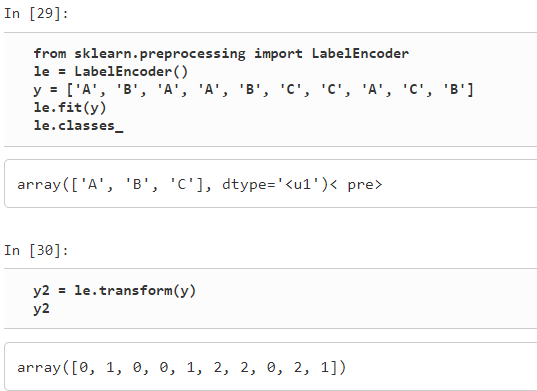

In [ ]:
def label_encoding(col):
    le = LabelEncoder()
    le.fit(list(train[col].values) + list(test[col].values))
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))
    # astype() : 데이터형 변경. 이경우 문자형으로 변경함
    
num_cols = train._get_numeric_data().columns
# _get_numeric_data() : 숫자형인 열만 걸러냄 
cat_cols = list(set(features) - set(num_cols))
for col in cat_cols:
    label_encoding(col)

8.3 Prepare Training and Validation Sets

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train[features].values, target, test_size=0.2, random_state=1)
# 교차검증. 
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid)

8.4 Baseline LightGBM

Gradient Boosting에서는 고차원 변수에 데이터 크기가 큰 경우 효뉼성과 확정성이 떨어진다. 이의 주된 원인으로는 각 변수마다 가능한 모든 분활점에 대해 정보 회득을 폄가하려면 데이터 개체 모두를 훑어야하기 때문에 시간이 많이 소요되기 때문이다. 이 문제를 해결하기 위해 기울기 기반 단측 표본 추출(GOSS), 배타적 변수 묶음(EFB)의 기술을 사용한 방법이 **LightGBM**이다.

GOSS를 통해 데이터 개체 중 기울기가 작은 상당 부분을 제외시키고 나머지만 사용하여 정보를 얻을 수 있다. 기울기가 큰 데이터 개체가 정보 획득 계산에 더 중요한 역할을 하기 때문에 GOSS는 훨씬 작은 크기의 데이터로 정보 획득을 매우 정확하게 추정해낼 수 있다. 
EFB를 통해 변수 개수를 줄이기 위해 상호 배타적 변수들(예컨대, 0이 아닌 값을 동시에 갖는 일이 거의 없는 변수들)을 묶는다. 배타적 변수의 최적 묶음을 찾는 일은 NP-hard지만 탐욕 알고리즘을 통해 매우 괜찮은 근사 비율을 얻을 수 있다. 따라서 분할점 결정 정확도를 크게 훼손시키지 않으면서 변수 개수를 효과적으로 줄일 수 있다. 

이러한 두가지의 방법을 이용하여 LightGBM은 Gradient Boosting에 비해 20배가 빠르면서도 정확도는 거의 동일하게 달성된다.

In [ ]:
params = {'boosting_type': 'gbdt', 'objective': 'multiclass', 'metric': 'multi_logloss',
          'num_class': 4, 'max_depth': 44, 'num_leaves': 36, 'learning_rate': 0.01,
          'feature_fraction': 0.8, 'bagging_fraction': 0.8, 'bagging_freq': 5,
          'lambda_l2': 1.0, 'verbose': -1, 'num_threads': -1 }

model = lgb.train(params, lgb_train, num_boost_round=100,  valid_sets=[lgb_train, lgb_valid], 
                  early_stopping_rounds=2000, verbose_eval=100)
# lgb_train : 훈련 데이터
# num_boost_round : 반복 횟수
# valid_set : 훈력 중 평가됨
# verbose_eval ( bool 또는 int , 선택 사항 ( 기본값 = True ) ) 하나 이상의 유효성 검사 데이터가 필요합니다. True이면 각 부스팅 단계에서 유효한 세트의 평가 메트릭이 인쇄됩니다. int 인 경우 유효한 세트의 평가 메트릭은 모든 verbose_eval부스팅 단계 에서 인쇄됩니다 . 마지막 부스트 단계 또는 사용하여 발견 된 부스팅 단계 early_stopping_rounds도 인쇄됩니다.

8.5 Predict and Submit

In [ ]:
## predictions
preds = model.predict(test[features], num_iteration=model.best_iteration)

## revert back to original classes
reverse_index = {}
for k,v in target_index.items():
    reverse_index[v] = k
preds = [reverse_index[np.argmax(p)] for p in preds]
# argmax : 값이 가장 큰 곳의 인덱스 반환

## submission
subs = pd.DataFrame()
subs['Id'] = test['Id']
subs['Target'] = preds
subs.to_csv('submission.csv', index=False)
subs.head()